### Initial Configurations

#### Import Libraries

In [32]:
#Import required Libraries
import os

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.image import imread
import cv2
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")


import azureml.core
import azureml.automl
#from azureml.core.experiment import Experiment
from azureml.core import Workspace, Dataset, Datastore

#Import Model specific libraries
from tensorflow.keras.preprocessing.image import ImageDataGenerator , load_img ,img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report,confusion_matrix

#### Autheticate the AML Workspace

In [3]:
#Autheticate the AML Workspace
workspace = Workspace.from_config()
output = {}
output['Subscription ID'] = workspace.subscription_id
output['Workspace Name'] = workspace.name
output['Resource Group'] = workspace.resource_group
output['Location'] = workspace.location
pd.set_option('display.max_colwidth', -1)
outputDf = pd.DataFrame(data = output, index = [''])
outputDf.T

,
Subscription ID,Redacted
Workspace Name,houston-techsummit-workspace
Resource Group,calcutta_demos
Location,eastus2


In [22]:
#data_folder = os.path.join(os.getcwd(), 'data')
#os.path.join(data_folder,"**/train-images-idx3-ubyte.gz"
#print (os.path.join(data_folder,"castingdata/casting_data/train/def_front/cast_def_0_1001.jpeg"))
image_path = os.path.join(data_folder,"castingdata/casting_data/casting_data/train/ok_front/cast_ok_0_1001.jpeg")
image_path
#os.path.isfile(image_path)

'/mnt/batch/tasks/shared/LS_root/mounts/clusters/compute-cpu-ds12-v2/code/Users/rabiswas/Manufacturing_Casting_Classification/Notebooks/data/castingdata/casting_data/casting_data/train/ok_front/cast_ok_0_1001.jpeg'

### Get Data

#### Upload folders

In [5]:
data_folder = os.path.join(os.getcwd(), 'data')
#/mnt/batch/tasks/shared/LS_root/mounts/clusters/compute-cpu-ds12-v2/code/Users/rabiswas/Manufacturing_Casting_Classification/Notebooks/data

#Create the data directory
os.makedirs(data_folder, exist_ok=True)

#Manually upload the folders from Kaggle

#### Visualize the image files

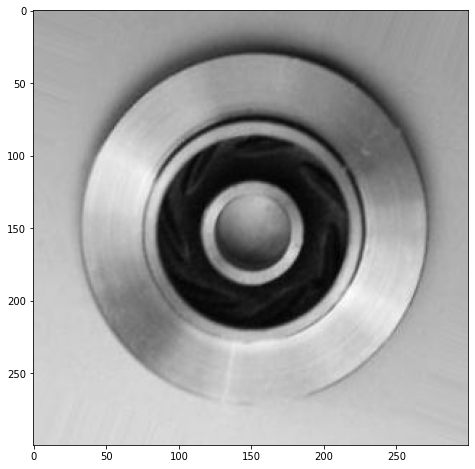

In [17]:
# view some casting images which are ok
image_path = os.path.join(data_folder,"castingdata/casting_data/casting_data/train/ok_front/cast_ok_0_1001.jpeg")
img = plt.imread(image_path)
plt.figure(figsize=(12,8))
plt.imshow(img,cmap='gray')

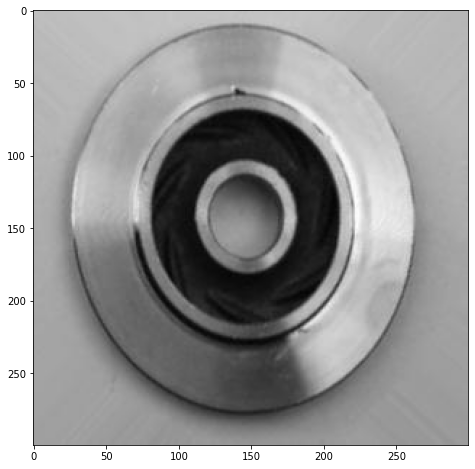

In [18]:
# view some casting images which are defective
image_path = os.path.join(data_folder,"castingdata/casting_data/casting_data/train/def_front/cast_def_0_1001.jpeg")
img = plt.imread(image_path)
plt.figure(figsize=(12,8))
plt.imshow(img,cmap='gray')

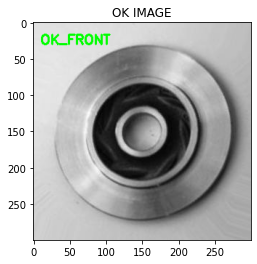

In [27]:
# view some casting images which are ok
image=cv2.imread("/mnt/batch/tasks/shared/LS_root/mounts/clusters/compute-cpu-ds12-v2/code/Users/rabiswas/Manufacturing_Casting_Classification/Notebooks/data/castingdata/casting_data/casting_data/train/ok_front/cast_ok_0_1005.jpeg")
plt.title("OK IMAGE")
cv2.putText(image, "OK_FRONT", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)
plt.imshow(image)

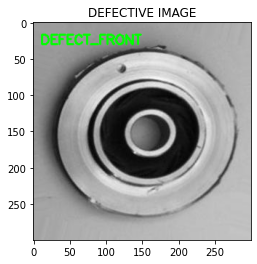

In [30]:
# view some casting images which are defective
image=cv2.imread("/mnt/batch/tasks/shared/LS_root/mounts/clusters/compute-cpu-ds12-v2/code/Users/rabiswas/Manufacturing_Casting_Classification/Notebooks/data/castingdata/casting_data/casting_data/train/def_front/cast_def_0_1007.jpeg")
plt.title("DEFECTIVE IMAGE")
cv2.putText(image, "DEFECT_FRONT", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)
plt.imshow(image)

### Data Preparation

Image Augmentation is a way of applying different types of transformation techniques on actual images, thus producing copies of the same image with alterations. This helps to train deep learning models on more image variations than what is present in the actual dataset.

This is especially useful when we do not have enough images to train the model on, hence we can use augmented images to enlarge the training set and provide more images to the model.

The ImageDataGenerator class in Keras is used for implementing image augmentation. The major advantage of the Keras ImageDataGenerator class is its ability to produce real-time image augmentation. This simply means it can generate augmented images dynamically during the training of the model making the overall mode more robust and accurate.



In [33]:
image_gen = ImageDataGenerator(rescale=1/255) # Rescale the image by normalizing it

In [35]:
casting_data_dir = os.path.join(data_folder,"castingdata/casting_data/casting_data/")
train_path = casting_data_dir + 'train/'
test_path = casting_data_dir + 'test/'

image_shape = (300,300,1)
batch_size = 32

#### flow_from_directory  -> Takes the path to a directory & generates batches of augmented data.

#### Arguments used
##### directory
string, path to the target directory. It should contain one subdirectory per class. Any PNG, JPG, BMP, PPM or TIF images inside each of the subdirectories directory tree will be included in the generator. See this script for more details.
#### target_size
Tuple of integers (height, width), defaults to (256,256). The dimensions to which all images found will be resized.
#### color_mode
One of "grayscale", "rgb", "rgba". Default: "rgb". Whether the images will be converted to have 1, 3, or 4 channels.
#### classes
Optional list of class subdirectories (e.g. ['dogs', 'cats']). Default: None. If not provided, the list of classes will be automatically inferred from the subdirectory names/structure under directory, where each subdirectory will be treated as a different class (and the order of the classes, which will map to the label indices, will be alphanumeric). The dictionary containing the mapping from class names to class indices can be obtained via the attribute class_indices.
#### class_mode
One of "categorical", "binary", "sparse", "input", or None. Default: "categorical". Determines the type of label arrays that are returned: - "categorical" will be 2D one-hot encoded labels, - "binary" will be 1D binary labels, "sparse" will be 1D integer labels, - "input" will be images identical to input images (mainly used to work with autoencoders). - If None, no labels are returned (the generator will only yield batches of image data, which is useful to use with model.predict()). Please note that in case of class_mode None, the data still needs to reside in a subdirectory of directory for it to work correctly.
#### batch_size
Size of the batches of data (default: 32).
#### shuffle
Whether to shuffle the data (default: True) If set to False, sorts the data in alphanumeric order.


In [36]:
#we using keras inbuild function to ImageDataGenerator so we do not need to label all images into 0 and 1 it automatic create it and batch also during trainng 

train_set = image_gen.flow_from_directory(train_path,
                                               target_size=image_shape[:2],
                                               color_mode="grayscale",
                                               batch_size=batch_size,
                                               class_mode='binary',shuffle=True)

test_set = image_gen.flow_from_directory(test_path,
                                               target_size=image_shape[:2],
                                               color_mode="grayscale",
                                               batch_size=batch_size,
                                               class_mode='binary',shuffle=False)

Found 6633 images belonging to 2 classes.
Found 715 images belonging to 2 classes.


In [37]:
train_set.class_indices

{'def_front': 0, 'ok_front': 1}

In [38]:
test_set.class_indices

{'def_front': 0, 'ok_front': 1}

### Convolutional model creation
https://www.tensorflow.org/api_docs/python/tf/keras

####  Keras Sequential Model
The first way of creating neural networks is with the help of the Keras Sequential Model. The basic idea behind this API is to just arrange the Keras layers in sequential order, this is the reason why this API is called Sequential Model. Even in most of the simple artificial neural networks, layers are put in sequential order, the flow of data takes place between layers in one direction.

Keras sequential model API is useful to create simple neural network architectures without much hassle. The only disadvantage of using the Sequential API is that it doesn’t allow us to build Keras models with multiple inputs or outputs. Instead, it is limited to just 1 input tensor and 1 output tensor.

This flow chart shown below depicts the functioning of Sequential API.
For adding layers to a sequential model, we can create different types of layers first and then use the add() function for adding them.

#### Keras Convolution Layer
Keras provides many ready-to-use layer API and Keras convolution layer is just one of them. It is used for creating convolutions over an image in the CNN model.
For two-dimensional inputs, such as images, they are represented by keras.layers.Conv2D: the Conv2D layer.

##### Attributes
__Filters__ represents the number of filters that should be learnt by the convolutional layer. From the schematic drawing above, you should understand that each filter slides over the input image, generating a “feature map” as output.
The __kernel size__ represents the number of pixels in height and width that should be summarized, i.e. the two-dimensional width and height of the filter.
The __stride__ tells us how the kernel jumps over the input image. If the stride is 1, it slides pixel by pixel. If it’s two, it jumps one pixel. It jumps two with a stride of 3, and so on.
The __padding__ tells us what happens when the kernels/filters don’t fit, for example because the input image has a width and height that do not match with the combination of kernel size and stride.
Depending on the backend you’re using Keras with, the channels (each image has image channels, e.g. 3 channels with Red-Green-Blue or RGB) are in the first dimension or the last. Hence, the __data format__ represents whether it’s a channels first or channels last approach. With recent versions of Keras, which support TensorFlow only, this is no longer a concern.
If you’re using dilated convolutions, the __dilation rate__ can be specified as well.
The __activation function__ to which the linear output of the Conv2D layer is fed to make it nonlinear can be specified too.
A __bias value__ can be added to each layer in order to scale the learnt function vertically. This possibly improves training results. It can be configured here, especially if you don’t want to use biases. By default, it’s enabled.
The __initializer__ for the kernels, the biases can be configured too, as well as __regularizers__ and __constraints__.

#### Model compilation and fitting the data
Keras allows you to do so quite easily: with model.compile and model.fit. The compile call allows you to specify the loss function, the optimizer and additional metrics, of which we use accuracy, as it’s intuitive to humans. Then, with fit, we can fit the input_train and target_train (i.e. the inputs and targets of our training set) to the model, actually starting the training process. We do so based on the options that we configured earlier, i.e. batch size, number of epochs, verbosity mode and validation split.


In [39]:
#Creating model

model = Sequential()

model.add(Conv2D(filters=8, kernel_size=(3,3),input_shape=image_shape, activation='relu',))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=16, kernel_size=(3,3),input_shape=image_shape, activation='relu',))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=16, kernel_size=(3,3),input_shape=image_shape, activation='relu',))
model.add(MaxPooling2D(pool_size=(2, 2)))

#### Keras Layers
Keras layers are the building blocks of the Keras library that can be stacked together just like legos for creating neural network models. This ease of creating neural networks is what makes Keras the preferred deep learning framework by many. There are different types of Keras layers available for different purposes while designing your neural network architecture. 

At a high-level Keras gives you two choices to create layers by using Keras Layers API and Keras Custom Layers.

1) Kera Layers API
Keras provides plenty of pre-built layers for different neural network architectures and purposes via its Keras Layers API.
These available layers are normally sufficient for creating most of the deep learning models with considerable flexibility.

Below are some of the popular Keras layers –

- Dense Layer
- Flattened Layer
- Dropout Layer
- Reshape Layer
- Permute Layer
- RepeatVector Layer
- Lambda Layer
- Pooling Layer
- Locally Connected Layer

2) Custom Keras Layers

Although Keras Layer API covers a wide range of possibilities it does not cover all types of use-cases. This is why Keras also provides flexibility to create our own custom layer to tailor-make it
as per our needs.  

Below are the ones we used:
1.  Dense Layer
Dense Layer is a widely used Keras layer for creating a deeply connected layer in the neural network where each of the neurons of the dense layers receives input from all neurons of the previous layer. At its core, it performs dot product of all the input values along with the weights for obtaining the output.
The dense layer’s output shape is altered by changing the number of neurons/units specified in the layer. Each and every layer has its own batch size as its first dimension.
2. Flatten Layer
As its name suggests, Flatten Layers is used for flattening of the input. For example, if we have an input shape as (batch_size, 3,3), after applying the flatten layer, the output shape is changed to (batch_size,9).

Flatten function has one argument as follows –

data_format – An optional argument, it mainly helps in preserving weight ordering when data formats are switched.
3. Pooling Layer
The pooling layer is used for applying max pooling operations on temporal data.

The syntax of the pooling layer function is shown below –

The pool_size refers the max pooling windows.
strides refer the factors for downscale.



In [ ]:
model.add(Flatten())

model.add(Dense(224))
model.add(Activation('relu'))

# Last layer
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
early_stop = EarlyStopping(monitor='val_loss',patience=2)

In [40]:
results = model.fit_generator(train_set,epochs=20,
                              validation_data=test_set,
                             callbacks=[early_stop])

Epoch 1/20
208/208 [==============================] - 635s 3s/step - loss: 0.6068 - accuracy: 0.6558 - val_loss: 0.4613 - val_accuracy: 0.7510
Epoch 2/20
208/208 [==============================] - 574s 3s/step - loss: 0.2695 - accuracy: 0.8967 - val_loss: 0.1417 - val_accuracy: 0.9455
Epoch 3/20
208/208 [==============================] - 484s 2s/step - loss: 0.1245 - accuracy: 0.9568 - val_loss: 0.1157 - val_accuracy: 0.9497
Epoch 4/20
208/208 [==============================] - 532s 3s/step - loss: 0.0776 - accuracy: 0.9748 - val_loss: 0.0626 - val_accuracy: 0.9818
Epoch 5/20
208/208 [==============================] - 493s 2s/step - loss: 0.0532 - accuracy: 0.9828 - val_loss: 0.0230 - val_accuracy: 0.9944
Epoch 6/20
208/208 [==============================] - 501s 2s/step - loss: 0.0

### Analizing model performance

In [41]:
losses = pd.DataFrame(model.history.history)

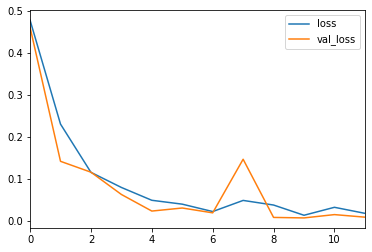

In [42]:
losses[['loss','val_loss']].plot()

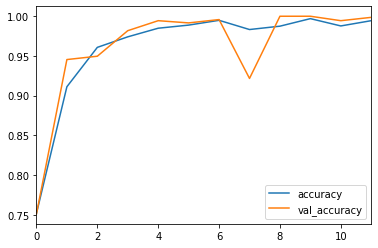

In [43]:
losses[['accuracy','val_accuracy']].plot()


In [44]:
#first we will find predict probability
pred_probability = model.predict_generator(test_set)

In [45]:
#here it's true label for test set
test_set.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [46]:
predictions = pred_probability > 0.5
#if model predict greater than 0.5 it conveted to 1 means ok_front

In [47]:
print(classification_report(test_set.classes,predictions))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       453
           1       1.00      1.00      1.00       262

    accuracy                           1.00       715
   macro avg       1.00      1.00      1.00       715
weighted avg       1.00      1.00      1.00       715



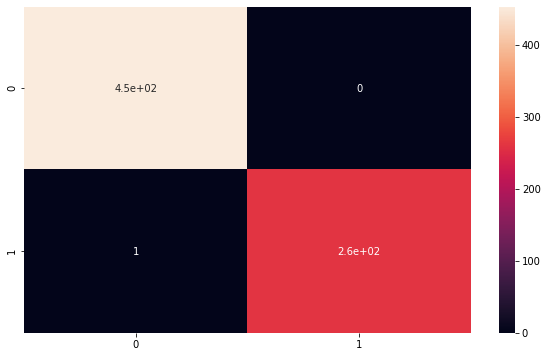

In [48]:
plt.figure(figsize=(10,6))
sns.heatmap(confusion_matrix(test_set.classes,predictions),annot=True)

### Predict on some test images

In [165]:
#img = cv2.imread('/mnt/batch/tasks/shared/LS_root/mounts/clusters/compute-cpu-ds12-v2/code/Users/rabiswas/Manufacturing_Casting_Classification/Notebooks/data/castingdata/casting_data/casting_data/test/ok_front/cast_ok_0_1020.jpeg')
img = cv2.imread('/mnt/batch/tasks/shared/LS_root/mounts/clusters/compute-cpu-ds12-v2/code/Users/rabiswas/Manufacturing_Casting_Classification/Notebooks/data/castingdata/casting_data/casting_data/test/ok_front/cast_ok_0_10.jpeg')
img = img/255 #rescaling
pred_img =img.copy()

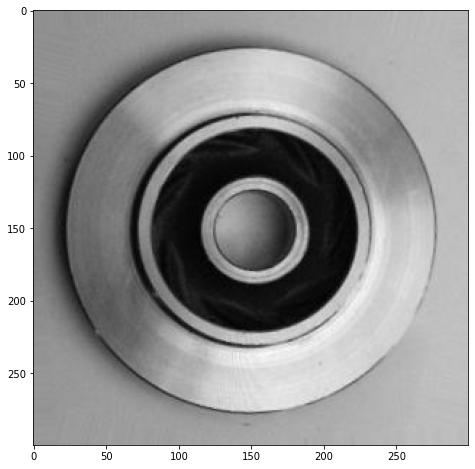

In [166]:
plt.figure(figsize=(12,8))
plt.imshow(img,cmap='gray')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


ok_front


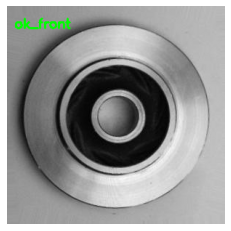

In [173]:
#prediction = model.predict(img.reshape(-1,300,300,1))
prediction = model.predict_classes(img.reshape(-1,300,300,1))
if (prediction.max() < 0.5):
    print("def_front")
    cv2.putText(pred_img, "def_front", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)
else:
    print("ok_front")
    cv2.putText(pred_img, "ok_front", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)
    
plt.imshow(pred_img,cmap='gray')
plt.axis('off')
plt.show()

In [177]:
#img1 = cv2.imread('/mnt/batch/tasks/shared/LS_root/mounts/clusters/compute-cpu-ds12-v2/code/Users/rabiswas/Manufacturing_Casting_Classification/Notebooks/data/castingdata/casting_data/casting_data/test/def_front/cast_def_0_1134.jpeg')
img1 = cv2.imread('/mnt/batch/tasks/shared/LS_root/mounts/clusters/compute-cpu-ds12-v2/code/Users/rabiswas/Manufacturing_Casting_Classification/Notebooks/data/castingdata/casting_data/casting_data/test/def_front/cast_def_0_1059.jpeg')

img1 = img1/255
pred_img1 =img1.copy()

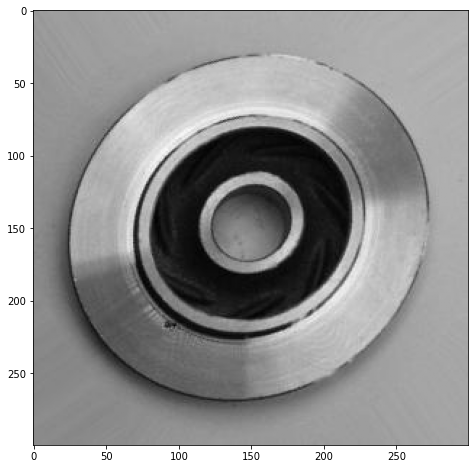

In [175]:
plt.figure(figsize=(12,8))
plt.imshow(img1,cmap='gray')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


def_front


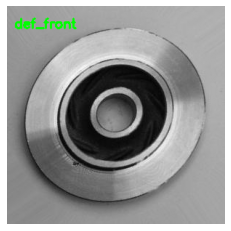

In [179]:
#prediction = model.predict(img1.reshape(-1,300,300,1))
prediction = model.predict_classes(img1.reshape(-1,300,300,1))
if (prediction.max()<0.5):
    print("def_front")
    cv2.putText(pred_img1, "def_front", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)
else:
    print("ok_front")
    cv2.putText(pred_img1, "ok_front", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)
    
plt.imshow(pred_img1,cmap='gray')
plt.axis('off')
plt.show()

### Saving the model

In [79]:
model.save('inspection_of_casting_products.h5')

### Model evaluation
The final step is to evaluate our model after we performed training. Keras allows you to do so with model.evaluate. We are using the unseen test datset. This way, we can be sure that we test the model with data that it hasn’t seen before during training, evaluating its power to generalize to new data. Evaluation is done in a non-verbose way, and the results are printed on screen.

In [87]:
def display_eval_metrics(e_data):
    msg='Model Metrics after Training'
    #print_in_color(msg, (255,255,0), (55,65,80))
    msg='{0:^24s}{1:^24s}'.format('Metric', 'Value')
    #print_in_color(msg, (255,255,0), (55,65,80))
    for key,value in e_data.items():
        print (f'{key:^24s}{value:^24.5f}')
    acc=e_data['accuracy']* 100
    return acc

In [92]:
#Accuracy on the test set
e_dict=model.evaluate( test_set, batch_size=batch_size, verbose=1, steps=None, return_dict=True)
acc=display_eval_metrics(e_dict)
print('accuracy of  model on the test set is %5.2f' %acc)

23/23 [==============================] - 26s 1s/step - loss: 0.0084 - accuracy: 0.9986
          loss                  0.00842         
        accuracy                0.99860         
accuracy of  model on the test set is 99.86
